# Afterwards we proceed with plotting the industrial pollution so that we account for the concentration and the spread of the pollution. We load the libraries...

In [2]:
library(tidyverse)
library(lubridate)

library(sp)

# install.packages("sf")
# library(sf)

library(raster)
library(leaflet) 
library(leaflet.esri)
library(leaflet.extras)

library(snakecase)

library(sf)
library(spData)

library(leaflet) # for interactive maps
library(mapview) # for interactive maps
library(ggplot2) # tidyverse vis package
library(shiny) # for web applications

library(maps)
library(devtools)

library(geojsonio)
library(rgdal)


# and the data

In [9]:
# Load data

# 1) Industrial
InitIndustrial <- read.csv("industrial_pollution_v2.csv") %>% 
  rename(Latitude = 'X.', Longitude = 'Y.', DeviceHeight = m, AnnualPM = 't.y')

# 2) Atmosphere profile
InitAtmoProfile <- read.csv("atmosphere_profile_train.csv") %>% 
  mutate_at(vars(Date), funs(as_date(.)))

  
# 3) Construction Sites
InitConstrSites <- read.csv("construction_sites.csv")

# 4) Sofia Topography
InitSofiaTopo <- read.csv("sofia_topo.csv")

# 5) Stations
InitStations <- read.csv("stations_data_train.csv")

# 6) Weather
InitWeather <- read.csv("weather_train.csv")

# 7) HH data
#InitHH <- read.csv("household_heating.csv")

# 8) Stations
StationLoc <- read.csv("Stations.csv")

# Some transformations

In [10]:
# Transform geolocation format in data on Industrial pollutants

Industrial <- InitIndustrial %>% 
  mutate_at(vars(Longitude, Latitude), funs(as.character)) %>% 
  mutate_at(vars(Longitude, Latitude), funs(sub('"', '', .))) %>% 
  mutate_at(vars(Longitude, Latitude), funs(sub('""', '\" ', .))) %>% 
  mutate_at(vars(Longitude, Latitude), funs(sub("''", "'", .))) %>% 
  mutate_at(vars(Longitude, Latitude), funs(substring(., 2))) %>% 
  mutate_at(vars(Longitude, Latitude), funs(str_sub(., 1, str_length(.)-2))) %>% 
  mutate_at(vars(Longitude, Latitude), funs(as.numeric(char2dms(., chd = "°", chm = "'", chs='"'))))


In [11]:
# Load Concentrations for day 1

# Load concentrations
newNames <- paste0(rep("Spread_", 10), 
                   c(1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000))

ConcInd <- read.csv("C1.csv") %>% 
  dplyr::select(-X) %>% 
  rename_all(~newNames) %>% 
  mutate(Latitude = Industrial$Latitude,
         Longitude = Industrial$Longitude) 

# A simple raster of topographic data

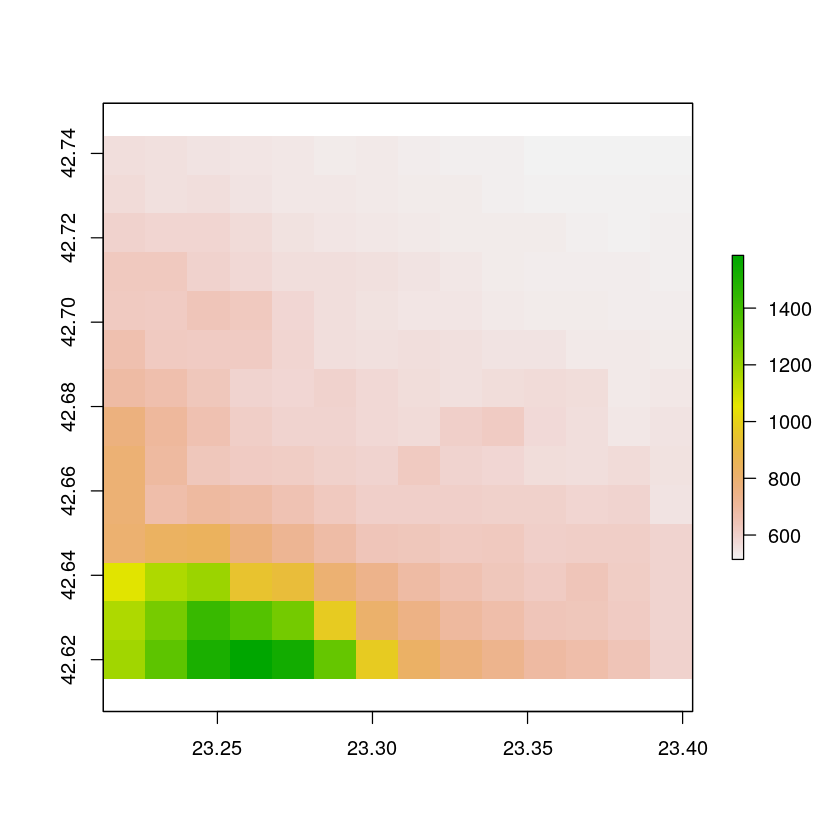

In [62]:
rast <- rasterFromXYZ(InitSofiaTopo[, c(2,1,3)])
plot(rast)

# Mapping

Create icons to embed in the map

In [12]:
industrialIcon <- makeIcon(
  iconUrl = "https://cdn3.iconfinder.com/data/icons/buildings-and-real-estates/30/factory-pollution-512.png",
  iconWidth = 55, iconHeight = 70,
  iconAnchorX = 22, iconAnchorY = 94
)

stationIcon <- makeIcon(
  iconUrl = "https://cdn3.iconfinder.com/data/icons/universal-web-5/83/201-512.png",
  iconWidth = 55, iconHeight = 70,
  iconAnchorX = 22, iconAnchorY = 94
)

In [13]:
head(Industrial)

Latitude,Longitude,DeviceHeight,AnnualPM
42.73796,23.24134,8,0.38
42.66278,23.38881,15,0.03
42.66291,23.38869,15,0.20
42.66297,23.38863,15,0.96
42.66309,23.38925,15,1.58
42.73229,23.31744,12,1.22


In [65]:
# PollutionMap <- leaflet() %>% 
#   
#   # Base groups
#   addProviderTiles(providers$Esri.WorldGrayCanvas, group = "Basic Map") %>% 
#   addProviderTiles(providers$Esri.WorldTopoMap, group = "Topo Map") %>%
#   
#   # Overlay groups
#   
#   # ------- industrial polluters
#   addMarkers(data = Industrial, ~Longitude, ~Latitude,
#              clusterOptions = markerClusterOptions(),
#              icon = industrialIcon, group = "Industrial Pollution") %>% 
# 
#   # ------ stations
#   addMarkers(data = StationLoc, ~Longitude, ~Latitude,
#              # clusterOptions = markerClusterOptions(),
#              icon = stationIcon, group = "Official Stations") %>% 
# 
#   addHeatmap(data = ConcInd, lng = ~Longitude, lat = ~Latitude,
#              intensity = ~Spread_1000, gradient = "Greys",
#              blur = 30, radius = 27,
#              minOpacity = 0.40,
#              group = "Industrial Pollution: Spread 1000 m") %>%
# 
#   addHeatmap(data = ConcInd, lng = ~Longitude, lat = ~Latitude,
#              intensity = ~Spread_2000, gradient = "Greys",
#              blur = 30, radius = 29,
#              minOpacity = 0.40,
#              group = "Industrial Pollution: Spread 2000 m") %>%
# 
#   addHeatmap(data = ConcInd, lng = ~Longitude, lat = ~Latitude,
#              intensity = ~Spread_3000, gradient = "Greys",
#              blur = 30, radius = 31,
#              minOpacity = 0.40,
#              group = "Industrial Pollution: Spread 3000 m") %>%
# 
#   addHeatmap(data = ConcInd, lng = ~Longitude, lat = ~Latitude,
#              intensity = ~Spread_4000, gradient = "Greys",
#              blur = 30, radius = 33,
#              minOpacity = 0.40,
#              group = "Industrial Pollution: Spread 4000 m") %>%
# 
#   addHeatmap(data = ConcInd, lng = ~Longitude, lat = ~Latitude,
#              intensity = ~Spread_5000, gradient = "Greys",
#              blur = 30, radius = 35,
#              minOpacity = 0.40,
#              group = "Industrial Pollution: Spread 5000 m") %>%
# 
#   addHeatmap(data = ConcInd, lng = ~Longitude, lat = ~Latitude,
#              intensity = ~Spread_6000, gradient = "Greys",
#              blur = 30, radius = 37,
#              minOpacity = 0.40,
#              group = "Industrial Pollution: Spread 6000 m") %>%
# 
#   addHeatmap(data = ConcInd, lng = ~Longitude, lat = ~Latitude,
#              intensity = ~Spread_7000, gradient = "Greys",
#              blur = 30, radius = 39,
#              minOpacity = 0.40,
#              group = "Industrial Pollution: Spread 7000 m") %>%
# 
#   addHeatmap(data = ConcInd, lng = ~Longitude, lat = ~Latitude,
#              intensity = ~Spread_8000, gradient = "Greys",
#              blur = 30, radius = 41,
#              minOpacity = 0.40,
#              group = "Industrial Pollution: Spread 8000 m") %>%
# 
#   addHeatmap(data = ConcInd, lng = ~Longitude, lat = ~Latitude,
#              intensity = ~Spread_9000, gradient = "Greys",
#              blur = 30, radius = 43,
#              minOpacity = 0.40,
#              group = "Industrial Pollution: Spread 9000 m") %>%
# 
#   addHeatmap(data = ConcInd, lng = ~Longitude, lat = ~Latitude,
#              intensity = ~Spread_10000, gradient = "Greys",
#              blur = 30, radius = 45,
#              minOpacity = 0.40,
#              group = "Industrial Pollution: Spread 10000 m") %>%
#   
#   addHeatmap(data = StationLoc, lng = ~Longitude, lat = ~Latitude,
#              intensity = ~2016-11-01, gradient = "Reds",
#              blur = 30, radius = 25,
#              minOpacity = 0.05,
#              group = "Pollution: Official Measurements") %>% 
# 
#   addLayersControl(
#     baseGroups = c("Topo Map", "Basic Map"),
#     overlayGroups = c("Official Stations", "Industrial Pollution", 
#                       "Pollution: Official Measurements",
#                       "Industrial Pollution: Spread 1000 m", "Industrial Pollution: Spread 2000 m", 
#                       "Industrial Pollution: Spread 3000 m", "Industrial Pollution: Spread 4000 m",
#                       "Industrial Pollution: Spread 5000 m", "Industrial Pollution: Spread 6000 m",
#                       "Industrial Pollution: Spread 7000 m", "Industrial Pollution: Spread 8000 m",
#                       "Industrial Pollution: Spread 9000 m", "Industrial Pollution: Spread 10000 m"),
#     options = layersControlOptions(collapsed = FALSE)
#   ) 

# Our articles on particles would be nothing without a proper map of the data! 

Our solution includes a map showcasing a few key aspects of air pollution in Sofia:
- Official measurement stations in Sofia
- Industrial pollutants
- Pollution concentration as measured by official stations in red
- Pollution concentration for industrial units in black

The intensity of the color reflects the degree of pollution:
- The bigger the circle, the farther the pollution spreads
- The darker the colour, the higher the concentration of particles 
    
The map is interactive and allows you, our curious readers, to explore the pollution in Sofia in several ways!
                            
- You may choose to look at a topographic map or a basic one
- You may view all elements or only some of them 
- The official stations button allows you to locate the measurement stations on the map
- Industrial pollutants may be identified as clusters of heavy polluters (depicted with counts) or as their specific locations once you zoom in
- The degree of pollution may be examined by the measure of spread - ranging from 1000 to 10,000 meters in radius from the pollutant

This map represents the first day of our historical data.

In [7]:
IRdisplay::display_html('<style>.container { width:100% !important; }</style>')
IRdisplay::display_html('<iframe src="Industrial Pollutants.html" width=1000, height=1000></iframe> ')